In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from transformers import AutoTokenizer, PreTrainedTokenizerFast, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from dictionary_learning import AutoEncoder
from nnsight import LanguageModel
from dictionary_learning.utils import read_csv
from IPython.display import display, HTML
import scipy.sparse
from scipy.sparse import csr_matrix
from dictionary_learning.sparse_feature_writer import SparseFeatureWriter

import gc
import h5py
from collections import defaultdict

In [2]:
tokenizer_filepath = "/gpfs/space/projects/stacc_health/gpt2_model/estMed-gpt2_fine_tuned4/estMed-gpt2_fine_tuned4/tokenizer.json"
tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_filepath)
tokenizer.pad_token = "<pad>"

h5file_path = "features/features100.h5"

In [3]:
def get_batch(batch_idx):
    batch_size = 512
    start_idx = batch_idx * batch_size
    
    with h5py.File(h5file_path, 'r') as f:
        shape = f.attrs['shape']
        csr = csr_matrix((f['data'][:], f['indices'][:], f['indptr'][:]), shape=shape)
        tokens_h5 = f['tokens'][start_idx:start_idx+batch_size]

    submatrix = csr[start_idx:start_idx + batch_size]
    
    return tokens_h5, submatrix

In [4]:
def token_top_features(batch_idx):
    batch_size = 512
    start_idx = batch_idx * batch_size
    
    with h5py.File(h5file_path, 'r') as f:
        shape = f.attrs['shape']
        csr = csr_matrix((f['data'][:], f['indices'][:], f['indptr'][:]), shape=shape)
        tokens_h5 = f['tokens'][:]
        
        # For each token
        for i, token in enumerate(tokens_h5[start_idx:start_idx+batch_size]):
            row = csr.getrow(start_idx + i)
            if row.nnz:
                topk_idx = row.indices[row.data.argsort()[::-1][:3]]
                topk_val = row.data[row.data.argsort()[::-1][:3]]
                print(f"{token} → features {topk_idx.tolist()} = {topk_val.tolist()}")

In [5]:
token_top_features(0)

321 → features [11257, 8048, 10334] = [21.490501403808594, 21.448265075683594, 11.616604804992676]
322 → features [5011, 8266, 8871] = [3.0666751861572266, 2.0153419971466064, 1.3793457746505737]
2469 → features [9454, 2791, 11426] = [1.7806077003479004, 1.0308059453964233, 0.7869168519973755]
773 → features [11149, 5903, 2378] = [0.861983060836792, 0.6991865634918213, 0.6093067526817322]
544 → features [5903, 1937, 10871] = [1.3473141193389893, 0.7340717315673828, 0.6217768788337708]
35199 → features [1937, 5903, 2422] = [2.761770725250244, 1.9354147911071777, 0.9457525014877319]
275 → features [4940, 11180, 8571] = [0.6835324764251709, 0.5330291986465454, 0.5232146978378296]
14 → features [10118, 6515, 8266] = [0.7866754531860352, 0.735838770866394, 0.6064928770065308]
4686 → features [11140, 9418, 11742] = [0.7971874475479126, 0.6148508787155151, 0.4137605130672455]
2022 → features [2121, 194, 3452] = [1.3183350563049316, 1.3170866966247559, 1.262961745262146]
12 → features [8249, 3

In [6]:
# given a specific feature and a batch of input text, outputs the feature's activation value for each token.

def feature_activations(batch_idx, feature_idx):  
    batch_tokens, batch_activations = get_batch(batch_idx)
     
    feature_column = batch_activations[:, feature_idx] # [batch_size, 1], still sparse
    feature_acts = feature_column.toarray().flatten() # Convert to dense numpy array (sparse column with zeros filled in)

    # Print given feature's activation value for each token
    print(f"Feature: {feature_idx}")
    for token, activation in zip(batch_tokens, feature_acts):
        decoded_token = tokenizer.decode(token)
        
        print(f"{decoded_token: >20} = {activation}")

In [7]:
feature_activations(0, 2492)

Feature: 2492
                NAME = 0.0
                   : = 0.0
               läheb = 0.0
                 pik = 0.0
                 ale = 0.0
          lennureisi = 0.0
                  le = 0.0
                   . = 0.0
                seal = 0.014521986246109009
              tunneb = 0.0
                   , = 0.04681111127138138
                  et = 0.0
                  ja = 0.0
               bajal = 0.0
                  ad = 0.0
           valutavad = 0.0
                   , = 0.0799911692738533
                kurk = 0.0
                  on = 0.0
                kuiv = 0.0
                köha = 0.0
                   . = 0.0
                 obj = 0.0
                   . = 0.06404208391904831
                kops = 0.0
               puhas = 0.0
                   , = 0.014405705034732819
                neel = 0.10011843591928482
             punetav = 0.0
                DATE = 0.0
                NAME = 0.0
                   : = 0.0
                  ta = 0.

In [8]:
def visualize_feature_activations(batch_idx, feature_idx):
    batch_tokens, batch_activations = get_batch(batch_idx)
     
    feature_column = batch_activations[:, feature_idx] # [batch_size, 1], still sparse
    feature_acts = feature_column.toarray().flatten() # Convert to dense numpy array (sparse column with zeros filled in)
    
    # Color mapping
    max_val = 30 
    min_val = 0
    forward = lambda x: x** (1/3) # function. Transforms the data values before applying the colormap.
    inverse = lambda x: x**3 # function. Transforms from the normalized scale [0, 1] back to the original data space.
    norm = matplotlib.colors.FuncNorm((forward, inverse), vmin=min_val, vmax=max_val) #(https://matplotlib.org/stable/users/explain/colors/colormapnorms.html)
    #norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
    cmap = matplotlib.colormaps.get_cmap('Oranges')

    # Build HTML with color highlighting
    html = ""
    for token, activation in zip(batch_tokens, feature_acts): 
        if token == 50257:
            continue
        decoded_token = tokenizer.decode(token)    
        color = matplotlib.colors.rgb2hex(cmap(norm(activation)))
        html += f'<span style="background-color:{color}; padding: 2px; margin: 2px; border-radius: 3px;">{decoded_token}</span> '

    display(HTML(html))

In [9]:
visualize_feature_activations(68, 1634)

In [10]:
def find_rarely_active_features(h5_path, threshold=1, max_occurrences=100):
    """
        h5_path (str): Path to the HDF5 file.
        threshold (float): Minimum activation to count as 'strong'.
        max_occurrences (int): Maximum allowed number of times a feature may exceed the threshold.
    """
    batch_size = 512
    
    with h5py.File(h5_path, 'r') as f:
        # Reconstruct CSR matrix
        shape = f.attrs['shape']
        features = csr_matrix((f['data'][:], f['indices'][:], f['indptr'][:]), shape=shape)
        tokens = f['tokens'][:]
    
    num_features = features.shape[1]
    activation_counts = np.zeros(num_features, dtype=int)
    activation_batches = defaultdict(set)
    token_tracker = defaultdict(list)

    # Iterate over rows (each token)
    for row_idx in range(len(tokens)): # = features.shape[0]
        batch_idx = row_idx // batch_size
        row = features.getrow(row_idx)
        strong_mask = row.data > threshold        
        strong_indices = row.indices[strong_mask]

        for feature_idx in strong_indices:
            activation_batches[feature_idx].add(batch_idx)
            activation_counts[feature_idx] += 1
            if len(token_tracker[feature_idx]) < max_occurrences:
                token_tracker[feature_idx].append(tokens[row_idx])

    # Identify rarely active features   
    rarely_active = []
    for i, count in enumerate(activation_counts):
        if count > 0 and count < max_occurrences:
            rarely_active.append(i)

    print(f"\n Found {len(rarely_active)} rarely active features (threshold > {threshold}, occurred < {max_occurrences} times):\n")

    for feature_idx in rarely_active:
        batches = sorted(list(activation_batches[feature_idx]))
        example_tokens = token_tracker[feature_idx]
        print(f"Feature {feature_idx} was strongly activated {activation_counts[feature_idx]} times.")
        decoded_tokens = [tokenizer.decode(token_idx) for token_idx in example_tokens]
        print(f"  Example tokens: {decoded_tokens}")
        print(f"  Appeared in batches: {batches}\n")

In [11]:
find_rarely_active_features(
    h5_path=h5file_path,
    threshold=1,
    max_occurrences=1000
)


 Found 1897 rarely active features (threshold > 1, occurred < 1000 times):

Feature 1 was strongly activated 106 times.
  Example tokens: [' sin', ':', '-', 'a', ' rr', ' ps', ' korda', '-', ' sapipõie', ',', ':', '-', ',', ' kaebused', ' ta', ' pikkus', ' sin', '.', 'ta', ' ja', ' liikuvus', ',', ' pingeta', ' dex', ' sin', ' veri', ' 8', '.', ',', ' mcv', ' mchc', ' 339', '.', '.', '3', ' 4', ' (', '/', ' natiiv', ' kontrast', ' pole', ',', ',', 'sed', ' põie', ' õhuke', ' destruktiivseid', ' ei', '8', ' 0', '9', ' 40', '0', ' DATE', ' 6', '2', ' DATE', ' :', ' 4', '54', ' DATE', ' :', ' 138', ' -', '/', 'l', '4', ' :', ' 190', ' :', ' -', 'mchc', ' 343', ' DATE', ' :', ' -', 'l', ' 20', '.', '2', ' :', ' -', 'm', ' 4', '4', ' DATE', ' :', ' -', ' koldelist', ' muutust', ',', ',', ' –', ' samuti', ' mediastiinumi', '.', '.', ' -', ' /', '7', 'norm', '.', ' 3', '.', ' fr', 'lv']
  Appeared in batches: [3, 6, 11, 13, 22, 24, 31, 33, 36, 41, 52, 61, 62, 72, 78, 79, 88, 92]

Feature 8 w

  Example tokens: [']', ' negatiivne', ']', ']', ']']
  Appeared in batches: [46, 76, 88]

Feature 6222 was strongly activated 4 times.
  Example tokens: [' 7502', '808', '6001', ' 6301']
  Appeared in batches: [13, 44, 78]

Feature 6225 was strongly activated 2 times.
  Example tokens: [' norm', ' tavalisel']
  Appeared in batches: [44, 78]

Feature 6259 was strongly activated 18 times.
  Example tokens: [' olnud', 's', ' korduvalt', ' tagasi', ' oli', ' sügisel', ' veebruaris', ' oli', ' lõpus', ' oli', ' pöördus', ' oli', ' hommikuti', ' tekkis', ' oli', ' tagasi', 'hiljuti', ' olnud']
  Appeared in batches: [8, 10, 12, 31, 46, 50, 54, 68, 87, 88, 97]

Feature 6261 was strongly activated 1 times.
  Example tokens: ['.-']
  Appeared in batches: [17]

Feature 6277 was strongly activated 2 times.
  Example tokens: ['-', '-']
  Appeared in batches: [11, 14]

Feature 6278 was strongly activated 3 times.
  Example tokens: [' -', ' -', ' mch']
  Appeared in batches: [31, 52]

Feature 6289 

  Example tokens: [' teostamine', ' antistreptolüsiin', ' 2', ' 2', ' 18', 't', ' suu', ' näo', ' suu', ' näo', ' l', ' kõhu', ' kõhu', ' teostamine', ' hdl', ' ldl', ' de', ' koldelis', 'hormoon', ' rdw', 'p', ' s', 'p', 'p', ' s', 'p', ' s', 'p', ' s', 'p', ' s', 'p', 'ldl', 'ldl', 'p', 'hdl', ' kompuutertomograafia', ' kompuutertomograafia', ' kt', ' fev', ' 13', '391']
  Appeared in batches: [0, 4, 13, 24, 30, 31, 35, 36, 41, 44, 46, 52, 61, 78, 92]

Feature 12024 was strongly activated 191 times.
  Example tokens: [' teostamine', '.', ' -', ' 2', ' hingamissagedus', ' saturatsioon', 'nu', ' ümber', 'r', 'br', ' alumine', 'klaud', 'kav', ' h', ' -', ':', ':', ' mm', ' kodutolmulest', ':', '.', 'pteronyssinus', ' segu', ';', ' kõrrelised', ' heintaimede', ' segu', ':', ')', ' ter', ':', ' kass', ' koer', '99', ':', 'ik', 'sk', '44', ' /', ' d', '79', '400', ' poolteist', ' esine', ' peenike', ' kiir', ':', 'aga', 'äige', ' <', ' <', '-', ' -', ' insul', 'av', ' mis', ' põhjustada', 

In [12]:
def plot_feature_activation_histogram(h5_path, feature_idx, bins=50, log_scale=True):
    with h5py.File(h5_path, 'r') as f:
        shape = f.attrs['shape']
        features = csr_matrix((f['data'][:], f['indices'][:], f['indptr'][:]), shape=shape)

    # Get all activations for the selected feature. non-zero activations will be retrieved since sparse matrix only holds those.
    col = features.getcol(feature_idx)
    values = col.data

    if len(values) == 0:
        print(f"No activations found for feature {feature_idx}.")
        return

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(values, bins=bins, color="royalblue", edgecolor="black", alpha=0.8)
    plt.title(f"Activation Strength Distribution for Feature {feature_idx}")
    plt.xlabel("Activation Strength")
    plt.ylabel("Count")
    if log_scale:
        plt.yscale('log')
        plt.ylabel("Count (log scale)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

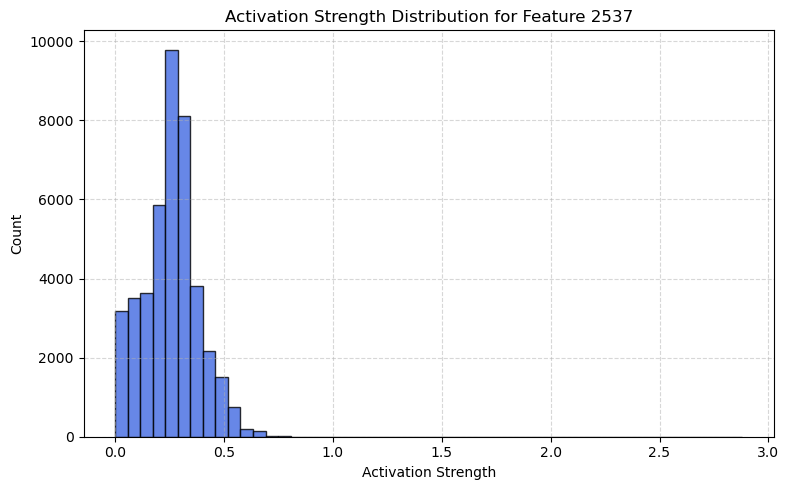

In [13]:
plot_feature_activation_histogram(h5file_path, feature_idx=2537 , bins=50, log_scale=False)

In [5]:
"""
tokenizerMistral = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

bnb_config = BitsAndBytesConfig(load_in_8bit=True)
modelMistral = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=bnb_config,
    #device_map="auto"  # Spread across available GPU/CPU
)

prompt = "<s>[INST] Explain Machine Learning to me in a nutshell. [/INST]"

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate response
with torch.no_grad():
    outputs = modelMistral.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.7,
        top_p=0.95,
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)
"""

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

ValueError: The following `model_kwargs` are not used by the model: ['token_type_ids'] (note: typos in the generate arguments will also show up in this list)

In [6]:
mistral_model_name = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(load_in_8bit=True)

tokenizerMistral = AutoTokenizer.from_pretrained(mistral_model_name)
modelMistral = AutoModelForCausalLM.from_pretrained(
    mistral_model_name, 
    quantization_config=bnb_config,
    device_map="auto", 
)

pipe = pipeline("text-generation", model=modelMistral, tokenizer=tokenizerMistral)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


In [15]:
def explain_feature(feature_idx, activating_tokens):
    prompt = (
        f"Tunnus {feature_idx} aktiveerub tugevasti järgmiste tokenite puhul.:\n"
        f"{', '.join(activating_tokens)}\n\n"
        f"Mis on nendel tokenitel ühist, mis viitaks tunnuse tähendusele. Seleta ühe lühikese lausega."
    )
    output = pipe(prompt, max_new_tokens=100, do_sample=False)
    return output[0]['generated_text'][len(prompt):].strip()

In [16]:
activating_tokens = ['ga', ' erakorraliselt', ' seoses', ' toodud', ' kiirabiga', ' patsiendina', 'osakonda', 'osakonda', ' hospitaliseeriti', ' erakorralisena', ' siseosakonda', ' haigena', 'osakonda', ' tekkinud']
mistralOutput = explain_feature(34, activating_tokens)
mistralOutput

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Nendel tokenitel ühest on mis seoses (what relates to), mis toodud (what was done), mis erakorraliselt (locally), mis kiirabiga (quickly), mis patsiendina (patiently), mis osakonda (participant), mis hospitaliseeriti (hospitalized), mis erakorralisena (locally), mis siseosakonda (home-based), mis'

In [13]:
def explain_feature_en(feature_idx, activating_tokens):
    prompt = (
        f"Feature {feature_idx} strongly activates on the following tokens:\n"
        f"{', '.join(activating_tokens)}\n\n"
        f"What pattern do these tokens have in common? Explain in one sentence."
    )
    output = pipe(prompt, max_new_tokens=100, do_sample=False)
    return output[0]['generated_text'][len(prompt):].strip()

In [14]:
activating_tokens = ['ga', ' erakorraliselt', ' seoses', ' toodud', ' kiirabiga', ' patsiendina', 'osakonda', 'osakonda', ' hospitaliseeriti', ' erakorralisena', ' siseosakonda', ' haigena', 'osakonda', ' tekkinud']
mistralOutput = explain_feature_en(34, activating_tokens)
mistralOutput

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"These tokens are Estonian words that contain the root 'osakonda' which means 'association' or 'organization'. The other tokens are various forms of the Estonian verb 'osakanna' which means 'to participate' or 'to be a member of'. Feature 34 is likely activated when it encounters these words due to their semantic similarity and frequent co-occurrence in text related to organizations and membership."